# Regression of Stock Market Values & Tweet Sentiment Analysis
## Karl Gilmartin, Eanna Bonner, Dara Newsome
### The code was created and submitted as part of "Data Analytics" in module CS4422

In [568]:
import pandas as pd
import re
import numpy as np
from datetime import date
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import plotly.express as px

import string


 Reading CSV files

In [1363]:
tweets = pd.read_csv('Tweet.csv')
company_tweet = pd.read_csv('Company_Tweet.csv')
result = pd.read_csv('result.csv')
stock = pd.read_csv('CompanyValues.csv')
train_df = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding="ISO-8859-1",names=['target','ids','date','flag','user','text'])
reaction = pd.read_csv('reaction.csv')

Sentiment Analysis -Cleaning

In [570]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 
             're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [571]:
STOPWORDS = set(stopwordlist)
def stopword_remover(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
tweets['body'] = tweets['body'].apply(lambda text: stopword_remover(text))
tweets['body'].head()

0    lx21 made $10,008 $AAPL -Check out! http://pro...
1    Insanity today weirdo massive selling. $aapl b...
2    S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...
3    $GM $TSLA: Volkswagen Pushes 2014 Record Recal...
4    Swing Trading: Up To 8.91% Return In 14 Days h...
Name: body, dtype: object

In [572]:
eng_punct = string.punctuation
punct_list = eng_punct
def clean_punct(text):
    translator = str.maketrans('', '', punct_list)
    return text.translate(translator)
tweets['body']= tweets['body'].apply(lambda x: clean_punct(x))
tweets['body'].head()

0    lx21 made 10008 AAPL Check out httpprofitly1Mn...
1    Insanity today weirdo massive selling aapl bid...
2    SP100 Stocks Performance HD LOW SBUX TGT DVN I...
3    GM TSLA Volkswagen Pushes 2014 Record Recall T...
4    Swing Trading Up To 891 Return In 14 Days http...
Name: body, dtype: object

In [573]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1{2,}', r'\1', text)
tweets['body'] = tweets['body'].apply(lambda x: cleaning_repeating_char(x))
tweets['body'].tail()

3717959    That SPY SPX pump last hour EOY EOQ EOM top wi...
3717960    In 2020 I may start Tweeting positive news XOM...
3717961    Patiently Waiting no twitter sitter tweets tsl...
3717962                      I dont discriminate I aapl msft
3717963    AAPL patent 10522475 Vertical interconnects se...
Name: body, dtype: object

In [574]:
def cleaning_URLs(datas):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',datas)
tweets['body'] = tweets['body'].apply(lambda x: cleaning_URLs(x))
tweets['body'].tail()

3717959    That SPY SPX pump last hour EOY EOQ EOM top wi...
3717960    In 2020 I may start Tweeting positive news XOM...
3717961    Patiently Waiting no twitter sitter tweets tsl...
3717962                      I dont discriminate I aapl msft
3717963    AAPL patent 10522475 Vertical interconnects se...
Name: body, dtype: object

In [575]:
def cleaning_numbers(datas):
    return re.sub('[0-9]+', '', datas)
tweets['body'] = tweets['body'].apply(lambda x: cleaning_numbers(x))
tweets['body'].tail()

3717959    That SPY SPX pump last hour EOY EOQ EOM top wi...
3717960    In  I may start Tweeting positive news XOM CVX...
3717961    Patiently Waiting no twitter sitter tweets tsl...
3717962                      I dont discriminate I aapl msft
3717963    AAPL patent  Vertical interconnects self shiel...
Name: body, dtype: object

COMPANIES

In [580]:
companies = result['ticker_symbol'].unique()
print(companies)
company_df = pd.DataFrame({'company': companies})

['AAPL' 'AMZN' 'TSLA' 'MSFT' 'GOOG' 'GOOGL']


In [581]:
company_df.head()

,company
0,AAPL
1,AMZN
2,TSLA
3,MSFT
4,GOOG


TWEETS

In [867]:
result.head()

,Unnamed: 0,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,ticker_symbol,reaction
0,0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL,Neutral
1,1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL,Negative
2,2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,AMZN,Negative
3,3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,TSLA,Neutral
4,4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,Neutral


In [868]:
result.tail()

,Unnamed: 0,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,ticker_symbol,reaction
4336440,4336440,1212159838882533376,ShortingIsFun,1577836401,In 2020 I may start Tweeting out positive news...,0,0,1,TSLA,Negative
4336441,4336441,1212160015332728833,Commuternyc,1577836443,Patiently Waiting for the no twitter sitter tw...,0,0,5,TSLA,Negative
4336442,4336442,1212160410692046849,MoriaCrypto,1577836537,I don't discriminate. I own both $aapl and $ms...,1,0,1,AAPL,Neutral
4336443,4336443,1212160410692046849,MoriaCrypto,1577836537,I don't discriminate. I own both $aapl and $ms...,1,0,1,MSFT,Neutral
4336444,4336444,1212160477159206912,treabase,1577836553,"$AAPL #patent 10,522,475 Vertical interconnect...",0,0,0,AAPL,Neutral


In [869]:
print(result.shape)

(4336445, 10)


In [870]:
result.describe()

,Unnamed: 0,tweet_id,post_date,comment_num,retweet_num,like_num
count,4.336445e+06,4.336445e+06,4.336445e+06,4.336445e+06,4.336445e+06,4.336445e+06
mean,2.168222e+06,8.834282e+17,1.499461e+09,2.923863e-01,6.347647e-01,2.103625e+00
std,1.251824e+06,1.927735e+17,4.596080e+07,1.885788e+00,6.986371e+00,1.371744e+01
min,0.000000e+00,5.504415e+17,1.420070e+09,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.084111e+06,7.185450e+17,1.460149e+09,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.168222e+06,8.825934e+17,1.499262e+09,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.252333e+06,1.054776e+18,1.540313e+09,0.000000e+00,0.000000e+00,1.000000e+00
max,4.336444e+06,1.212160e+18,1.577837e+09,6.310000e+02,9.990000e+02,9.990000e+02


In [871]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4336445 entries, 0 to 4336444
Data columns (total 10 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   Unnamed: 0     int64 
 1   tweet_id       int64 
 2   writer         object
 3   post_date      int64 
 4   body           object
 5   comment_num    int64 
 6   retweet_num    int64 
 7   like_num       int64 
 8   ticker_symbol  object
 9   reaction       object
dtypes: int64(6), object(4)
memory usage: 330.8+ MB


In [1364]:
result = result.replace('Negative', -1)
result = result.replace('Neutral', 0)
result = result.replace('Positive', 1)

In [873]:
result.head(10)

,Unnamed: 0,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,ticker_symbol,reaction
0,0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL,0
1,1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL,-1
2,2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,AMZN,-1
3,3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,TSLA,0
4,4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,0
5,5,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,TSLA,0
6,6,550443808606126081,aaplstocknews,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,0
7,7,550443808606126081,aaplstocknews,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,TSLA,0
8,8,550443809700851716,iknowfirst,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,0
9,9,550443809700851716,iknowfirst,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,TSLA,0


In [1365]:
dates = []
def toDate(num):
    temp = datetime.fromtimestamp(int(num))
    dates.append(temp)


In [1366]:
for date in result['post_date']:
    toDate(date)

In [1367]:
result['date'] = dates

In [1368]:
result['date'] = pd.to_datetime(result['date']).dt.date

In [1370]:
result = result.drop(['Unnamed: 0'], axis=1)

In [1371]:
result = result.drop(['post_date'], axis=1)

In [1372]:
result.head()

,tweet_id,writer,body,comment_num,retweet_num,like_num,ticker_symbol,reaction,date
0,550441509175443456,VisualStockRSRC,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL,0,2015-01-01
1,550441672312512512,KeralaGuy77,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL,-1,2015-01-01
2,550441732014223360,DozenStocks,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,AMZN,-1,2015-01-01
3,550442977802207232,ShowDreamCar,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,TSLA,0,2015-01-01
4,550443807834402816,i_Know_First,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,0,2015-01-01


Checking for Null Values

In [1373]:
result.isnull().values.any()


True

In [1374]:
result.isnull().sum().sum()

55919

[Text(0.5, 1.0, 'Missing Data')]

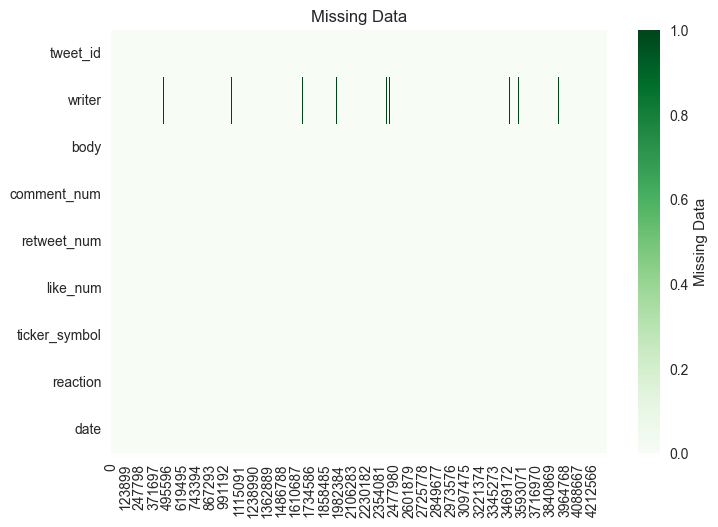

In [1375]:
# plt.figure(figsize=(10,6))
sns.heatmap(result.isna().transpose(),
            cmap="Greens",
            cbar_kws={'label': 'Missing Data'}).set(title="Missing Data")

In [887]:
result['writer'] = result['writer'].fillna("Unknown Author")

In [888]:
result['writer'].isnull().values.any()

False

In [ ]:
result = result.drop('writer', axis=1)


NUMBER OF TWEETS RELATING TO EACH COMPANY

In [890]:
num_tweets_company = result.groupby(result['ticker_symbol'].tolist(), as_index=False).size()

In [891]:
num_tweets_company.head()

,index,size
0,AAPL,1425013
1,AMZN,718715
2,GOOG,392569
3,GOOGL,327569
4,MSFT,375711


Text(0.5, 1.0, 'Number of tweets releated to companies')

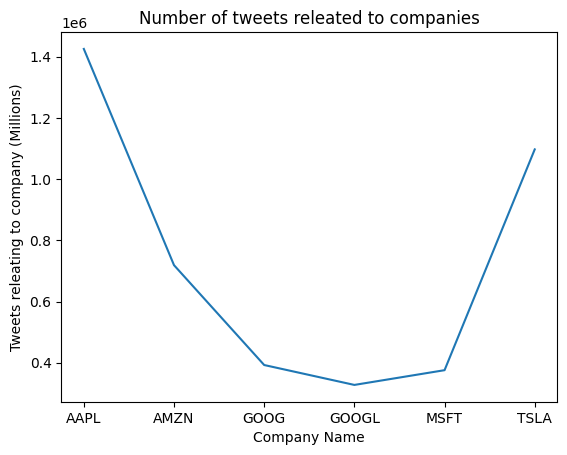

In [892]:
plt.plot( num_tweets_company['index'], num_tweets_company['size'])
plt.ylabel('Tweets releating to company (Millions)')
plt.xlabel('Company Name')
plt.title('Number of tweets releated to companies')

In [1035]:
company_tweet_likes = []
company_tweet_retweet = []
company_tweet_comment = []
for name in companies:
    company_tweet_comment.append(result.loc[result['ticker_symbol'] == name, 'comment_num'].sum())
    company_tweet_likes.append(result.loc[result['ticker_symbol'] == name, 'like_num'].sum())
    company_tweet_retweet.append(result.loc[result['ticker_symbol'] == name, 'retweet_num'].sum())
print('Likes per company',company_tweet_likes)
print('Retweets per company',company_tweet_retweet)
print('Comments per company',company_tweet_comment)

Likes per company [1378670, 984166, 5769051, 347520, 235928, 406917]
Retweets per company [722396, 419783, 1078386, 193364, 147143, 191550]
Comments per company [222048, 152200, 762813, 41533, 30704, 58619]


In [1041]:
data = [['Likes', 1378670,984166, 5769051, 347520, 235928, 406917 ],
        ['Retweets',722396, 419783, 1078386, 193364, 147143, 191550 ],
        ['Comments', 222048, 152200, 762813, 41533, 30704, 58619]]
df_info = pd.DataFrame(data, columns =['reaction', 'AAPL', 'AMZN', 'TSLA', 'MSFT', 'GOOG', 'GOOGL'])
df_info

,reaction,AAPL,AMZN,TSLA,MSFT,GOOG,GOOGL
0,Likes,1378670,984166,5769051,347520,235928,406917
1,Retweets,722396,419783,1078386,193364,147143,191550
2,Comments,222048,152200,762813,41533,30704,58619


In [1049]:
long_df = px.data.medals_long()

fig = px.bar(df_info, x="reaction", y=['AAPL', 'AMZN', 'TSLA', 'MSFT', 'GOOG', 'GOOGL'], title="Long-Form Input",width=800, height=800, color_discrete_sequence=["#76B947", "#B1D8B7", "#2F5233", "#94C973", "#08313A", '#32CD30'] )
fig.show()

In [896]:
result.head()

,tweet_id,body,comment_num,retweet_num,like_num,ticker_symbol,reaction,date
0,550441509175443456,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL,0,2015-01-01
1,550441672312512512,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL,-1,2015-01-01
2,550441732014223360,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,AMZN,-1,2015-01-01
3,550442977802207232,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,TSLA,0,2015-01-01
4,550443807834402816,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,0,2015-01-01


Dropping Colmuns wheich will not be used in model


In [902]:
# df = (result.loc[(result['date'] >= datetime(2018, 1, 1).date()) & (result['date'] <= datetime(2020, 1, 1).date())])
df = result
df.tail()
df_reduce = df
df_reduce = df_reduce.drop('tweet_id', axis=1)
df_reduce = df_reduce.drop('comment_num', axis=1)
df_reduce = df_reduce.drop('retweet_num', axis=1)
df_reduce = df_reduce.drop('like_num', axis=1)

Reducing dataframe to only Amazon

In [903]:
df_reduce = df_reduce.loc[df_reduce['ticker_symbol'] == 'AMZN']

In [1386]:
df_reduce.head(4)

,body,ticker_symbol,reaction,date
0,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,AMZN,-1,2015-01-01
1,Top 10 searched #stocks of #2014 $AAPL $FB $BA...,AMZN,1,2015-01-01
2,RT @SeekingAlpha: A Look At BlackBerry's Deals...,AMZN,0,2015-01-01
3,Jeff Bezos lost $7.4 billion in Amazon's worst...,AMZN,-1,2015-01-01


<Axes: >

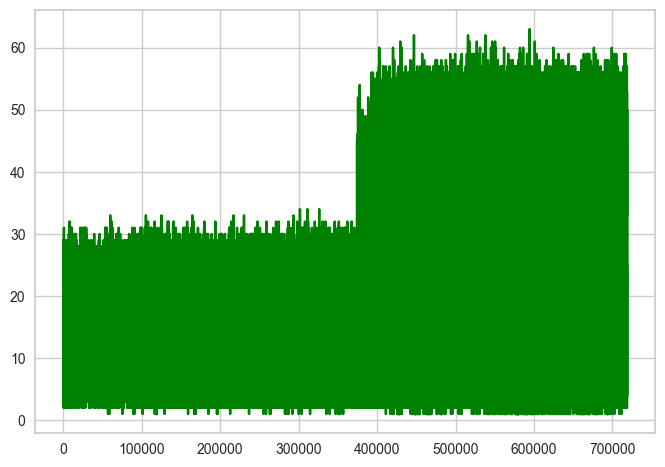

In [1388]:
body_len = df_reduce['body'].str.split().str.len()
body_len.plot.line(color='green', )


In [908]:
df_reduce = df_reduce.reset_index(drop=True)
df_reduce.to_csv('data.csv', index=False)

In [909]:
df_reduce.shape

(718715, 4)

In [910]:
unique_days = df_reduce['date'].unique()
print(len(unique_days))

1826


In [911]:
data = {'date': [0],'AMZN': 0 }
df_sum= pd.DataFrame(data)
df_sum.head()


,date,AMZN
0,0,0


Getting sentiment score for every unique day and adding it into dataframe


In [912]:
days = df_reduce['date'].unique()
print(date)
for date in days:
    
    AMZN = ((result.loc[(result['ticker_symbol'] == 'AMZN' )& (result['date'] == date), 'reaction'].sum())/ (len(result.loc[(result['ticker_symbol'] == 'AMZN' )& (result['date'] == date)])))
    data = {'date': [date],'AMZN': AMZN }
    df_sum = df_sum.append(data, ignore_index=True)

1577836553


/var/folders/f0/zf6fxcgs5t778nd1ml7j0xlr0000gn/T/ipykernel_1361/279423811.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/f0/zf6fxcgs5t778nd1ml7j0xlr0000gn/T/ipykernel_1361/279423811.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/f0/zf6fxcgs5t778nd1ml7j0xlr0000gn/T/ipykernel_1361/279423811.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/f0/zf6fxcgs5t778nd1ml7j0xlr0000gn/T/ipykernel_1361/279423811.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/f0/zf6fxcgs5t778nd1ml7j0xlr0000gn/T/ipykernel_1361/279423811.py:7: FutureWarning:

The frame.append method is deprecated and wi

In [915]:
df_sum.head()

,date,AMZN
0,0,0.000000
1,[2015-01-01],-0.145038
2,[2015-01-02],0.241379
3,[2015-01-03],0.298507
4,[2015-01-04],0.223529


Dropping test row

In [916]:
df_sum = df_sum.drop(0)



In [917]:
df_sum = df_sum.reset_index(drop=True)

In [918]:
df_sum.head()

,date,AMZN
0,[2015-01-01],-0.145038
1,[2015-01-02],0.241379
2,[2015-01-03],0.298507
3,[2015-01-04],0.223529
4,[2015-01-05],0.323843


In [919]:
# df_sum.to_csv('year.csv', index=False)

In [920]:
reaction.head()

,date,AAPL,AMZN,TSLA,MSFT,GOOG,GOOGL
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"[datetime.date(2015, 1, 1)]",0.257525,-0.145038,0.171717,0.277778,0.383333,0.444444
2,"[datetime.date(2015, 1, 2)]",0.163783,0.241379,0.268657,0.317757,0.344828,0.288288
3,"[datetime.date(2015, 1, 3)]",0.416185,0.298507,0.145833,0.271186,0.658228,0.807143
4,"[datetime.date(2015, 1, 4)]",0.389163,0.223529,0.210526,0.411765,0.495283,0.857143


In [1195]:
reaction.loc[1551]
# 1493
# 1551

date     [datetime.date(2019, 3, 31)]
AAPL                         0.505495
AMZN                         0.534759
TSLA                         0.137371
MSFT                         0.349515
GOOG                         0.257143
GOOGL                        0.428571
Name: 1551, dtype: object

In [624]:
reaction = reaction.drop(0, index=)


In [625]:
reaction.head()

,date,AAPL,AMZN,TSLA,MSFT,GOOG,GOOGL
1,"[datetime.date(2015, 1, 1)]",0.257525,-0.145038,0.171717,0.277778,0.383333,0.444444
2,"[datetime.date(2015, 1, 2)]",0.163783,0.241379,0.268657,0.317757,0.344828,0.288288
3,"[datetime.date(2015, 1, 3)]",0.416185,0.298507,0.145833,0.271186,0.658228,0.807143
4,"[datetime.date(2015, 1, 4)]",0.389163,0.223529,0.210526,0.411765,0.495283,0.857143
5,"[datetime.date(2015, 1, 5)]",0.223191,0.323843,0.287770,0.151786,0.404682,0.610390


In [626]:
reaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 1 to 1826
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1826 non-null   object 
 1   AAPL    1823 non-null   float64
 2   AMZN    1826 non-null   float64
 3   TSLA    1826 non-null   float64
 4   MSFT    1826 non-null   float64
 5   GOOG    1825 non-null   float64
 6   GOOGL   1826 non-null   float64
dtypes: float64(6), object(1)
memory usage: 100.0+ KB


In [1341]:
tsla_stocks = pd.read_csv('stocks.csv')

In [1342]:
tsla_stocks = tsla_stocks.loc[tsla_stocks['ticker_symbol'] == 'TSLA']

tsla_stocks = tsla_stocks.reset_index(drop=True)

In [1343]:
tsla_stocks.iloc[2627]

ticker_symbol          TSLA
day_date         2019-01-31
close_value          307.02
volume             12545190
open_value            301.0
high_value         311.5636
low_value             294.0
Name: 2627, dtype: object

In [1344]:
tsla_stocks.iloc[2689]

ticker_symbol          TSLA
day_date         2019-04-03
close_value          291.81
volume              7916650
open_value           287.32
high_value           296.17
low_value            287.17
Name: 2689, dtype: object

In [1345]:
tsla_stocks = tsla_stocks[2627:2689]

In [1346]:

tsla_stocks = tsla_stocks.reset_index(drop=True)

In [1347]:
tsla_stocks.tail()

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
57,TSLA,2019-03-29,279.86,5980355,278.70,280.16,274.500
58,TSLA,2019-03-30,279.86,5980355,278.70,280.16,274.500
59,TSLA,2019-03-31,279.86,5980355,278.70,280.16,274.500
60,TSLA,2019-04-01,289.18,8093134,282.62,289.20,281.281
61,TSLA,2019-04-02,285.88,5427184,288.30,289.44,283.880


# karl

In [973]:
stocks = pd.read_csv('stocks.csv')

In [974]:

stocks.head()

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
0,AMZN,2010-06-01,123.2400,3650661,124.9700,126.5720,123.0200
1,AAPL,2010-06-01,37.2614,218455576,37.0986,37.9914,36.9943
2,GOOGL,2010-06-01,243.6667,2664303,242.6868,248.0565,242.5302
3,MSFT,2010-06-01,25.8900,76120800,25.5300,26.3100,25.5200
4,GOOGL,2010-06-02,249.2233,2513109,245.8439,249.4759,243.2071


In [1148]:
plt.figure(figsize=(10,6))
sns.heatmap(stocks.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'}).set(title='Missing Data')

TypeError: 'Figure' object is not callable

In [655]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17528 entries, 0 to 17527
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ticker_symbol  17528 non-null  object 
 1   day_date       17528 non-null  object 
 2   close_value    17528 non-null  float64
 3   volume         17528 non-null  int64  
 4   open_value     17528 non-null  float64
 5   high_value     17528 non-null  float64
 6   low_value      17528 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 958.7+ KB


In [925]:
print(stocks.shape)

(17528, 7)


In [657]:
stocks.describe()

,close_value,volume,open_value,high_value,low_value
count,17528.000000,1.752800e+04,17528.000000,17528.000000,17528.000000
mean,455.167040,2.025441e+07,455.314451,459.710597,450.466694
std,469.324583,3.322733e+07,469.588291,473.771691,464.794791
min,15.800000,7.932000e+03,16.140000,16.630000,14.980000
25%,100.300000,2.075086e+06,99.883750,100.927500,98.940000
50%,256.500000,4.835618e+06,256.095000,259.604500,252.177400
75%,735.630000,2.704358e+07,735.740000,742.000000,728.920025
max,2497.940000,4.624423e+08,2500.000000,2525.450000,2467.270000


In [975]:
stocks = stocks.loc[5954:]

In [976]:
stocks.head()

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
5954,MSFT,2015-01-01,46.45,21551090,46.73,47.44,46.45
5955,AAPL,2015-01-01,110.38,41304780,112.82,113.13,110.21
5956,TSLA,2015-01-01,222.41,2392947,223.09,225.68,222.25
5957,GOOG,2015-01-01,526.40,1367110,531.25,532.60,525.80
5958,AMZN,2015-01-01,310.35,2048676,311.55,312.98,310.01


In [977]:
stocks = stocks.reset_index(drop=True)

In [978]:
stocks.head()

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
0,MSFT,2015-01-01,46.45,21551090,46.73,47.44,46.45
1,AAPL,2015-01-01,110.38,41304780,112.82,113.13,110.21
2,TSLA,2015-01-01,222.41,2392947,223.09,225.68,222.25
3,GOOG,2015-01-01,526.40,1367110,531.25,532.60,525.80
4,AMZN,2015-01-01,310.35,2048676,311.55,312.98,310.01


In [979]:

stocks.shape

(11574, 7)

In [980]:
stocks = stocks.loc[stocks['ticker_symbol'] == 'AMZN']

stocks = stocks.reset_index(drop=True)

In [981]:
stocks.iloc[1825]

ticker_symbol          AMZN
day_date         2019-12-31
close_value         1847.84
volume              2510380
open_value           1842.0
high_value          1853.26
low_value           1832.23
Name: 1825, dtype: object

In [982]:
stocks = stocks.loc[:1825]

In [983]:
stocks.tail()

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
1821,AMZN,2019-12-27,1869.80,6188754,1882.92,1901.40,1866.01
1822,AMZN,2019-12-28,1869.80,6188754,1882.92,1901.40,1866.01
1823,AMZN,2019-12-29,1869.80,6188754,1882.92,1901.40,1866.01
1824,AMZN,2019-12-30,1846.89,3677306,1874.00,1884.00,1840.62
1825,AMZN,2019-12-31,1847.84,2510380,1842.00,1853.26,1832.23


/var/folders/f0/zf6fxcgs5t778nd1ml7j0xlr0000gn/T/ipykernel_1361/2887538280.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,i+1)


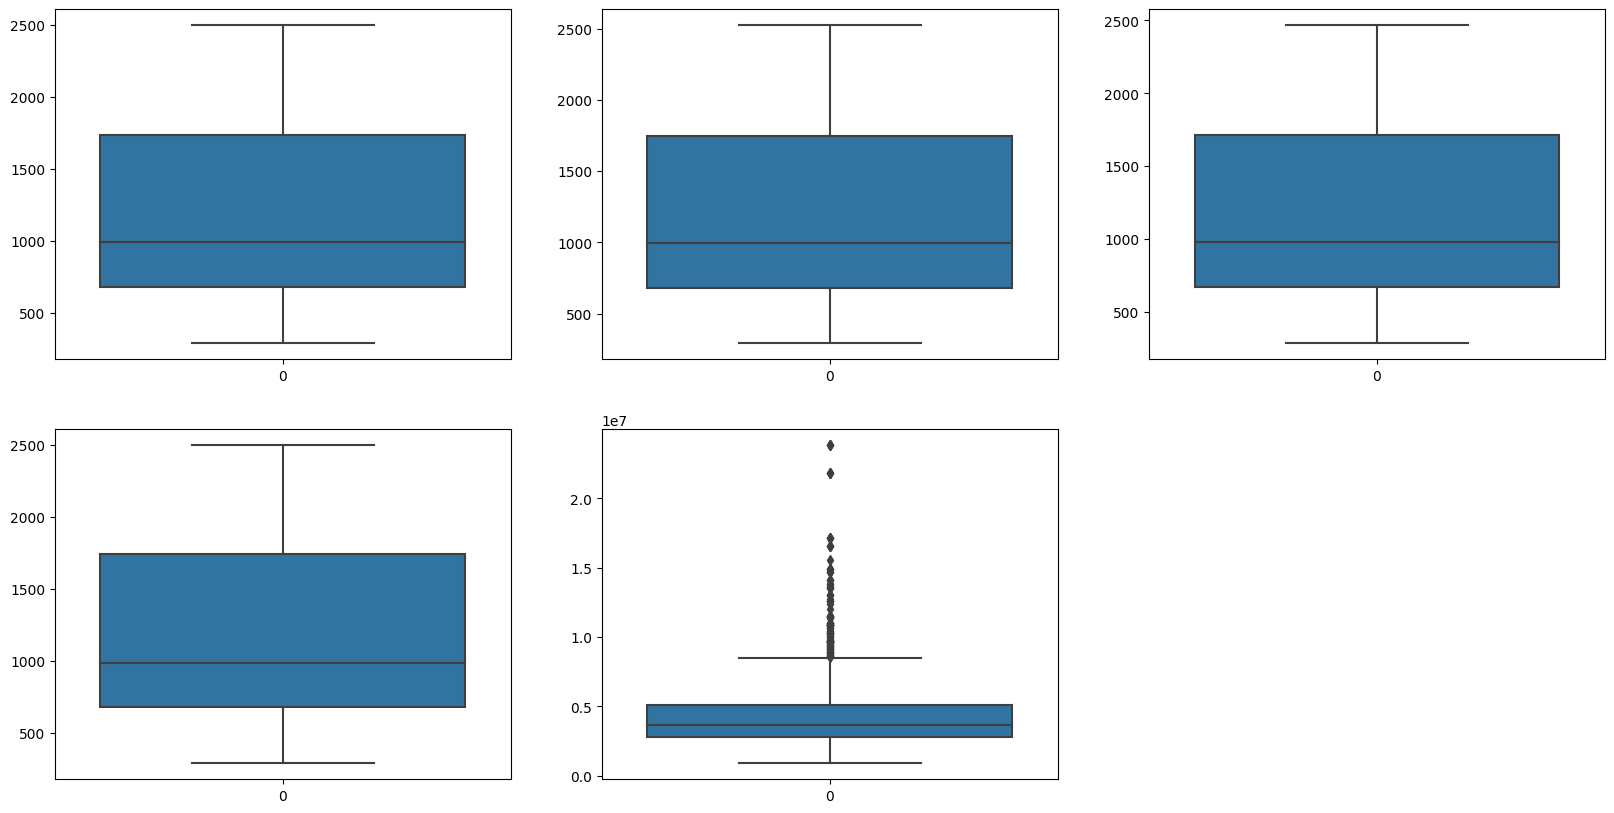

In [354]:
features = ['open_value', 'high_value', 'low_value', 'close_value', 'volume']
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sns.boxplot(stocks[col])
plt.show()

In [398]:
vals = stocks['open_value', 'close_value']
print(vals)

KeyError: ('open_value', 'close_value')

In [984]:
stocks1 = stocks
stocks1 = stocks1.drop('day_date', axis=1)


In [985]:
stocks1 = stocks1.drop('ticker_symbol', axis = 1)

In [986]:
stocks1.head()

,close_value,volume,open_value,high_value,low_value
0,310.35,2048676,311.55,312.98,310.0100
1,308.52,2785167,312.58,314.75,306.9601
2,308.52,2785167,312.58,314.75,306.9601
3,308.52,2785167,312.58,314.75,306.9601
4,302.19,2768215,307.01,308.38,300.8500


/var/folders/f0/zf6fxcgs5t778nd1ml7j0xlr0000gn/T/ipykernel_1361/3528010614.py:4: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



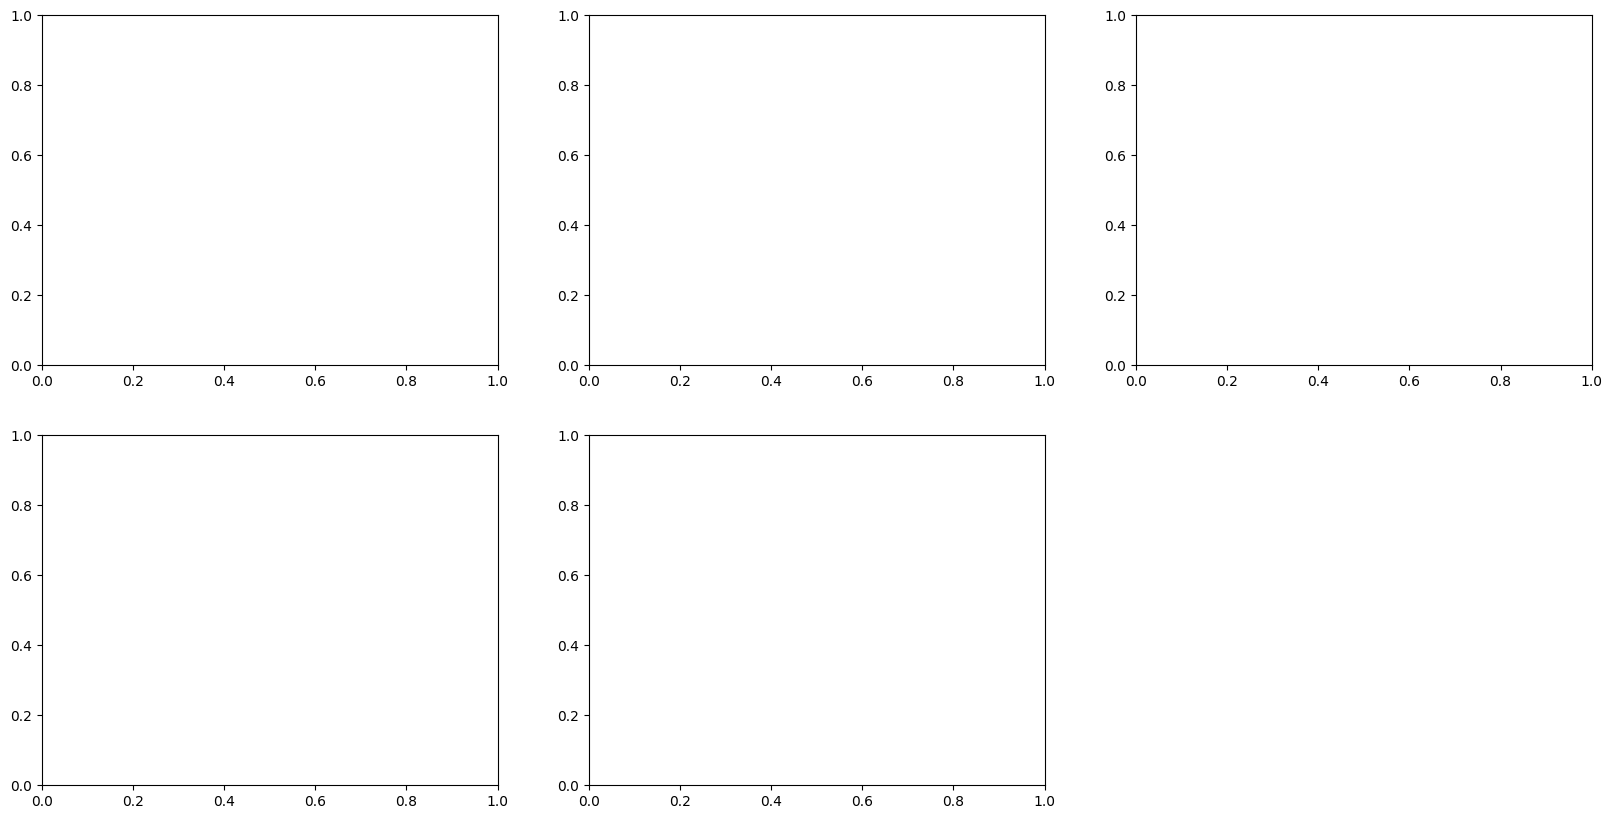

In [419]:
features = ['open_value', 'high_value', 'low_value', 'close_value', 'volume']
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  px.box(stocks[col])
plt.show()

In [1230]:
stocks1 = stocks1.drop('volume', axis = 1)
fig = px.box(stocks1, )
fig.show()

ValueError: Value of 'color' is not the name of a column in 'data_frame'. Expected one of ['close_value', 'open_value', 'high_value', 'low_value'] but received: Greens

In [ ]:

fig = px.box(stocks1)
fig.show()

In [987]:
stocks.head()

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
0,AMZN,2015-01-01,310.35,2048676,311.55,312.98,310.0100
1,AMZN,2015-01-02,308.52,2785167,312.58,314.75,306.9601
2,AMZN,2015-01-03,308.52,2785167,312.58,314.75,306.9601
3,AMZN,2015-01-04,308.52,2785167,312.58,314.75,306.9601
4,AMZN,2015-01-05,302.19,2768215,307.01,308.38,300.8500


In [988]:
# stocks = (stocks.loc[(stocks['day_date'] >= datetime(2018, 1, 1)) & (stocks['day_date'] <= datetime(2019, 1, 1))])
stocks.loc[1096]
# 1096

ticker_symbol          AMZN
day_date         2018-01-01
close_value         1169.47
volume              2678122
open_value          1182.35
high_value           1184.0
low_value            1167.5
Name: 1096, dtype: object

In [989]:
stocks.loc[1825]


ticker_symbol          AMZN
day_date         2019-12-31
close_value         1847.84
volume              2510380
open_value           1842.0
high_value          1853.26
low_value           1832.23
Name: 1825, dtype: object

In [666]:
# stocks = stocks.loc[1096:1825]
# 1491

In [990]:
stocks.tail()


,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
1821,AMZN,2019-12-27,1869.80,6188754,1882.92,1901.40,1866.01
1822,AMZN,2019-12-28,1869.80,6188754,1882.92,1901.40,1866.01
1823,AMZN,2019-12-29,1869.80,6188754,1882.92,1901.40,1866.01
1824,AMZN,2019-12-30,1846.89,3677306,1874.00,1884.00,1840.62
1825,AMZN,2019-12-31,1847.84,2510380,1842.00,1853.26,1832.23


In [991]:
stocks.head()

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
0,AMZN,2015-01-01,310.35,2048676,311.55,312.98,310.0100
1,AMZN,2015-01-02,308.52,2785167,312.58,314.75,306.9601
2,AMZN,2015-01-03,308.52,2785167,312.58,314.75,306.9601
3,AMZN,2015-01-04,308.52,2785167,312.58,314.75,306.9601
4,AMZN,2015-01-05,302.19,2768215,307.01,308.38,300.8500


In [668]:
stocks = stocks.reset_index(drop=True)
# stocks = stocks.drop('volume', axis=1)
# stocks = stocks.drop('low_value', axis=1)
# stocks = stocks.drop('high_value', axis=1)



In [669]:
stocks.head()

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
0,AMZN,2018-01-01,1169.47,2678122,1182.35,1184.0000,1167.50
1,AMZN,2018-01-02,1189.01,2673958,1172.00,1190.0000,1170.51
2,AMZN,2018-01-03,1204.20,3094175,1188.30,1205.4900,1188.30
3,AMZN,2018-01-04,1209.59,3015997,1205.00,1215.8699,1204.66
4,AMZN,2018-01-05,1229.14,3536299,1217.51,1229.1400,1210.00


In [670]:
stocks

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
0,AMZN,2018-01-01,1169.47,2678122,1182.35,1184.0000,1167.50
1,AMZN,2018-01-02,1189.01,2673958,1172.00,1190.0000,1170.51
2,AMZN,2018-01-03,1204.20,3094175,1188.30,1205.4900,1188.30
3,AMZN,2018-01-04,1209.59,3015997,1205.00,1215.8699,1204.66
4,AMZN,2018-01-05,1229.14,3536299,1217.51,1229.1400,1210.00
...,...,...,...,...,...,...,...
725,AMZN,2019-12-27,1869.80,6188754,1882.92,1901.4000,1866.01
726,AMZN,2019-12-28,1869.80,6188754,1882.92,1901.4000,1866.01
727,AMZN,2019-12-29,1869.80,6188754,1882.92,1901.4000,1866.01
728,AMZN,2019-12-30,1846.89,3677306,1874.00,1884.0000,1840.62


In [671]:
df_sum

,date,AMZN
0,[2018-01-01],0.522059
1,[2018-01-02],0.428862
2,[2018-01-03],0.335366
3,[2018-01-04],0.397436
4,[2018-01-05],0.395387
...,...,...
725,[2019-12-27],0.407563
726,[2019-12-28],0.411765
727,[2019-12-29],0.447368
728,[2019-12-30],0.424474


In [992]:
sentiments = []
for val in df_sum['AMZN']:
    sentiments.append(val)
    # stocks['sentiment'] = val
print((sentiments))
stocks['sentiment'] = sentiments

[-0.1450381679389313, 0.2413793103448276, 0.29850746268656714, 0.2235294117647059, 0.3238434163701068, 0.3058252427184466, 0.15463917525773196, 0.21395348837209302, 0.25853658536585367, 0.12280701754385964, 0.21153846153846154, 0.2565217391304348, 0.3026634382566586, 0.23591549295774647, 0.20357142857142857, 0.18012422360248448, 0.031914893617021274, 0.14864864864864866, 0.37815126050420167, 0.41409691629955947, 0.3472222222222222, 0.1801470588235294, 0.21804511278195488, 0.16806722689075632, 0.2222222222222222, 0.2857142857142857, 0.2388663967611336, 0.3859060402684564, 0.29851973684210525, 0.2877397831526272, 0.1951219512195122, 0.2222222222222222, 0.27298850574712646, 0.3870246085011186, 0.29692832764505117, 0.31016042780748665, 0.2247191011235955, 0.2808988764044944, 0.21428571428571427, 0.34946236559139787, 0.2554347826086957, 0.1813186813186813, 0.22105263157894736, 0.28502415458937197, 0.19791666666666666, 0.1411042944785276, 0.24778761061946902, 0.26618705035971224, 0.402010050

In [673]:
stocks['close_value']

0      1169.47
1      1189.01
2      1204.20
3      1209.59
4      1229.14
        ...   
725    1869.80
726    1869.80
727    1869.80
728    1846.89
729    1847.84
Name: close_value, Length: 730, dtype: float64

In [993]:
stocks.head()

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value,sentiment
0,AMZN,2015-01-01,310.35,2048676,311.55,312.98,310.0100,-0.145038
1,AMZN,2015-01-02,308.52,2785167,312.58,314.75,306.9601,0.241379
2,AMZN,2015-01-03,308.52,2785167,312.58,314.75,306.9601,0.298507
3,AMZN,2015-01-04,308.52,2785167,312.58,314.75,306.9601,0.223529
4,AMZN,2015-01-05,302.19,2768215,307.01,308.38,300.8500,0.323843


In [675]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

In [994]:
stocks= stocks.drop('ticker_symbol', axis=1)

In [995]:
stocks.head()

,day_date,close_value,volume,open_value,high_value,low_value,sentiment
0,2015-01-01,310.35,2048676,311.55,312.98,310.0100,-0.145038
1,2015-01-02,308.52,2785167,312.58,314.75,306.9601,0.241379
2,2015-01-03,308.52,2785167,312.58,314.75,306.9601,0.298507
3,2015-01-04,308.52,2785167,312.58,314.75,306.9601,0.223529
4,2015-01-05,302.19,2768215,307.01,308.38,300.8500,0.323843


In [996]:
stocks['Price Diff'] = stocks['close_value'].diff()

In [997]:
stocks.head()

,day_date,close_value,volume,open_value,high_value,low_value,sentiment,Price Diff
0,2015-01-01,310.35,2048676,311.55,312.98,310.0100,-0.145038,NaN
1,2015-01-02,308.52,2785167,312.58,314.75,306.9601,0.241379,-1.83
2,2015-01-03,308.52,2785167,312.58,314.75,306.9601,0.298507,0.00
3,2015-01-04,308.52,2785167,312.58,314.75,306.9601,0.223529,0.00
4,2015-01-05,302.19,2768215,307.01,308.38,300.8500,0.323843,-6.33


In [998]:
stocks = stocks.drop(0)
stocks.reset_index(drop=True)

,day_date,close_value,volume,open_value,high_value,low_value,sentiment,Price Diff
0,2015-01-02,308.52,2785167,312.58,314.75,306.9601,0.241379,-1.83
1,2015-01-03,308.52,2785167,312.58,314.75,306.9601,0.298507,0.00
2,2015-01-04,308.52,2785167,312.58,314.75,306.9601,0.223529,0.00
3,2015-01-05,302.19,2768215,307.01,308.38,300.8500,0.323843,-6.33
4,2015-01-06,295.29,3511003,302.24,303.00,292.3800,0.305825,-6.90
...,...,...,...,...,...,...,...,...
1820,2019-12-27,1869.80,6188754,1882.92,1901.40,1866.0100,0.407563,1.03
1821,2019-12-28,1869.80,6188754,1882.92,1901.40,1866.0100,0.411765,0.00
1822,2019-12-29,1869.80,6188754,1882.92,1901.40,1866.0100,0.447368,0.00
1823,2019-12-30,1846.89,3677306,1874.00,1884.00,1840.6200,0.424474,-22.91


In [1000]:
stocks = stocks.reset_index(drop=True)

In [1001]:
stocks.head()

,day_date,close_value,volume,open_value,high_value,low_value,sentiment,Price Diff
0,2015-01-02,308.52,2785167,312.58,314.75,306.9601,0.241379,-1.83
1,2015-01-03,308.52,2785167,312.58,314.75,306.9601,0.298507,0.00
2,2015-01-04,308.52,2785167,312.58,314.75,306.9601,0.223529,0.00
3,2015-01-05,302.19,2768215,307.01,308.38,300.8500,0.323843,-6.33
4,2015-01-06,295.29,3511003,302.24,303.00,292.3800,0.305825,-6.90


In [1002]:
stocks['amount'] = stocks['volume'] * ((stocks['open_value'] +stocks['close_value'])/2)

In [1003]:
stocks.head()

,day_date,close_value,volume,open_value,high_value,low_value,sentiment,Price Diff,amount
0,2015-01-02,308.52,2785167,312.58,314.75,306.9601,0.241379,-1.83,8.649336e+08
1,2015-01-03,308.52,2785167,312.58,314.75,306.9601,0.298507,0.00,8.649336e+08
2,2015-01-04,308.52,2785167,312.58,314.75,306.9601,0.223529,0.00,8.649336e+08
3,2015-01-05,302.19,2768215,307.01,308.38,300.8500,0.323843,-6.33,8.431983e+08
4,2015-01-06,295.29,3511003,302.24,303.00,292.3800,0.305825,-6.90,1.048965e+09


In [1004]:
st = stocks
st = st.drop('day_date', axis=1)


In [1005]:
from sklearn.preprocessing import MinMaxScaler
st_copy = st.copy()
 #We create a copy so we can still refer to the original dataframe later
scaler = MinMaxScaler()

st_columns = st.columns
st_scaled = pd.DataFrame(scaler.fit_transform(st_copy), columns=st_columns)
st_scaled.head()

,close_value,volume,open_value,high_value,low_value,sentiment,Price Diff,amount
0,0.012308,0.082900,0.015013,0.013616,0.012566,0.453015,0.513402,0.011580
1,0.012308,0.082900,0.015013,0.013616,0.012566,0.521527,0.520233,0.011580
2,0.012308,0.082900,0.015013,0.013616,0.012566,0.431608,0.520233,0.011580
3,0.008696,0.082162,0.011833,0.009996,0.009029,0.551911,0.496603,0.010674
4,0.004759,0.114506,0.009110,0.006939,0.004127,0.530303,0.494475,0.019244


In [863]:
stocks[['Price Diff', 'sentiment']]

,Price Diff,sentiment
1,19.54,0.428862
2,15.19,0.335366
3,5.39,0.397436
4,19.55,0.395387
5,0.00,0.472868
...,...,...
725,1.03,0.407563
726,0.00,0.411765
727,0.00,0.447368
728,-22.91,0.424474


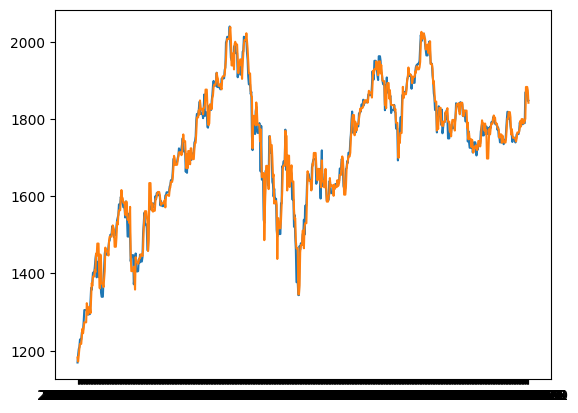

In [368]:
x_val = stocks['close_value']

y_val = stocks['day_date']
plt.plot(y_val, x_val)
plt.plot(stocks['open_value'])

In [1119]:
st_scaled.head()

,close_value,volume,open_value,high_value,low_value,sentiment,Price Diff,amount
0,0.012308,0.082900,0.015013,0.013616,0.012566,0.453015,0.513402,0.011580
1,0.012308,0.082900,0.015013,0.013616,0.012566,0.521527,0.520233,0.011580
2,0.012308,0.082900,0.015013,0.013616,0.012566,0.431608,0.520233,0.011580
3,0.008696,0.082162,0.011833,0.009996,0.009029,0.551911,0.496603,0.010674
4,0.004759,0.114506,0.009110,0.006939,0.004127,0.530303,0.494475,0.019244


In [1117]:
print(st_scaled.iloc[:, :-1].values)

[[0.01230771 0.08289999 0.01501287 ... 0.01256553 0.45301467 0.51340152]
 [0.01230771 0.08289999 0.01501287 ... 0.01256553 0.52152659 0.52023294]
 [0.01230771 0.08289999 0.01501287 ... 0.01256553 0.43160788 0.52023294]
 ...
 [0.90316451 0.23110509 0.91141264 ... 0.91492403 0.70005063 0.52023294]
 [0.89009221 0.12174711 0.90632082 ... 0.90022862 0.67259433 0.43470957]
 [0.89063427 0.07093472 0.88805421 ... 0.89537259 0.62654459 0.5237793 ]]


In [1216]:
features = ['sentiment', 'amount']
# features = 'sentiment'
target = [ 'close_value' ]

In [1231]:
X_train, X_test, y_train, y_test = train_test_split(st_scaled[features], st_scaled[target], test_size=0.3, random_state=42)
# 0.1 --> 88%
# 0.3 --> 79%
print(len(X_test))

548


In [1233]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score, mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, recall_score
regressor = RandomForestRegressor(n_estimators = 100, random_state = 20)
regressor.fit(X_train, y_train)
accuracy = regressor.score(X_test, y_test)
y_pred_test = regressor.predict(X_test)
y_pred_train = regressor.predict(X_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mape_test =mean_absolute_percentage_error(y_test, y_pred_test)
# recall_test = recall_score(y_test, y_pred_test)
rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred_test)), '.3f'))

# print(y_pred)
print(f"The accuracy of the model is {round(accuracy,3)*100} %")
print(f"The MAE training model is {round(mae_train,3)*100} %")
print(f"The MAE testing model is {round(mae_test,3)*100} %")
print(f"The MSE training model is {round(mse_train,3)*100} %")
print(f"The MSE testing model is {round(mse_test,3)*100} %")
print(f"The MSE testing model is {round(mse_test,3)*100} %")
print(f"The MAPE  model is {round(mape_test,3)*100} %")
print("\nRMSE: ", rmse)
print('Indicaticting a good model')
print('R2 score is:',r2_score(y_test, regressor.predict(X_test)))

# confusion_matrix(y_test, y_pred_test)

The accuracy of the model is 69.69999999999999 %
The MAE training model is 4.2 %
The MAE testing model is 11.799999999999999 %
The MSE training model is 0.4 %
The MSE testing model is 2.7 %
The MSE testing model is 2.7 %
The MAPE  model is 44.3 %

RMSE:  0.165
Indicaticting a good model
R2 score is: 0.6974548957407664


/var/folders/f0/zf6fxcgs5t778nd1ml7j0xlr0000gn/T/ipykernel_1361/3803716976.py:4: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestRegressor was fitted without feature names

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestRegressor was fitted without feature names

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestRegressor was fitted without feature names

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestRegressor was fitted without feature names



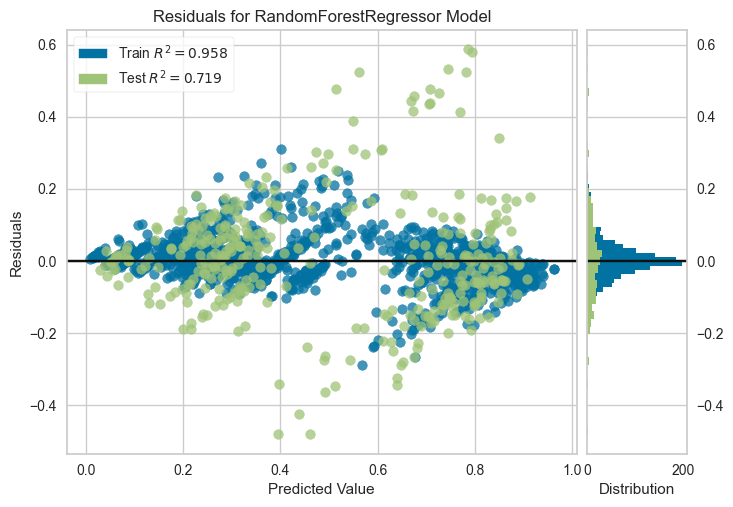

<Axes: title={'center': 'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [1158]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(regressor)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

In [1139]:
print(X_train)

      sentiment    amount
859    0.523317  0.058488
1022   0.615719  0.072012
170    0.492539  0.057413
292    0.501877  0.053759
1146   0.580326  0.363078
...         ...       ...
1130   0.565101  0.639826
1294   0.493028  0.323718
860    0.426534  0.061901
1459   0.528332  0.411064
1126   0.515534  0.506006

[1460 rows x 2 columns]


In [1091]:
print('Importance of features are:', regressor.feature_importances_)

Importance of features are: [0.13660279 0.86339721]


In [1225]:
model = LinearRegression()
model.fit(X_train,y_train)
model.score(X_test,y_test)


0.4613403095461578

score = 1899*
https://stackabuse.com/linear-regression-in-python-with-scikit-learn/

In [737]:
print(len(y_test))
print(len(X_test))
print(len(X_train))
print(len(y_train))

73
73
656
656


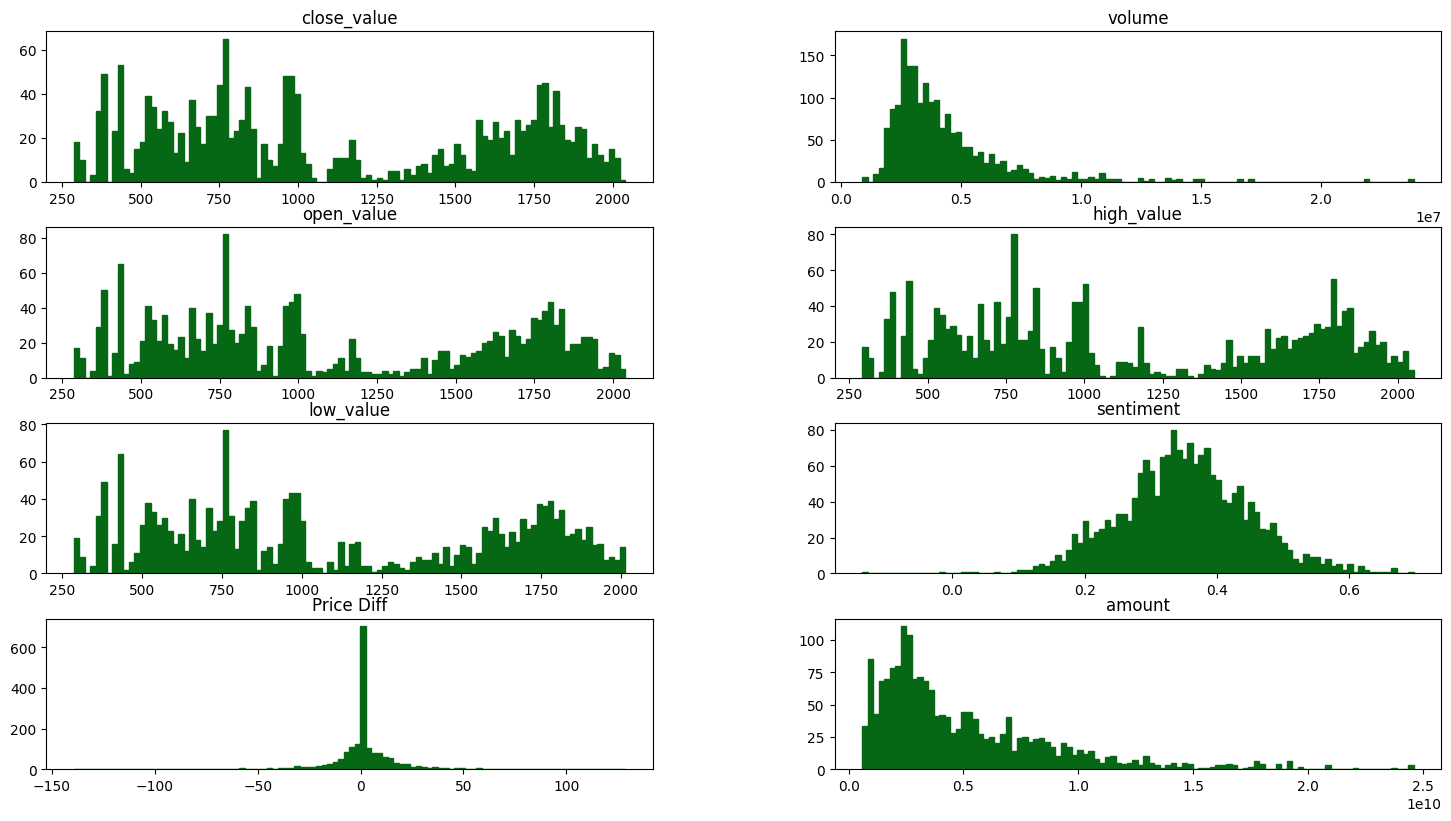

In [1022]:
stock_col = (stocks.columns)
stocks[stock_col].hist(stacked=False, bins=100, figsize=(18,35), layout=(14,2), color= "#066715", ec="#066715", grid=False);

In [1226]:
print(model.intercept_)

[-0.01871633]


In [1227]:
print(model.coef_)

[[0.44472017 1.27063822]]


In [86]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_true, y_pred)

NameError: name 'y_true' is not defined

/var/folders/f0/zf6fxcgs5t778nd1ml7j0xlr0000gn/T/ipykernel_1361/3487781266.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



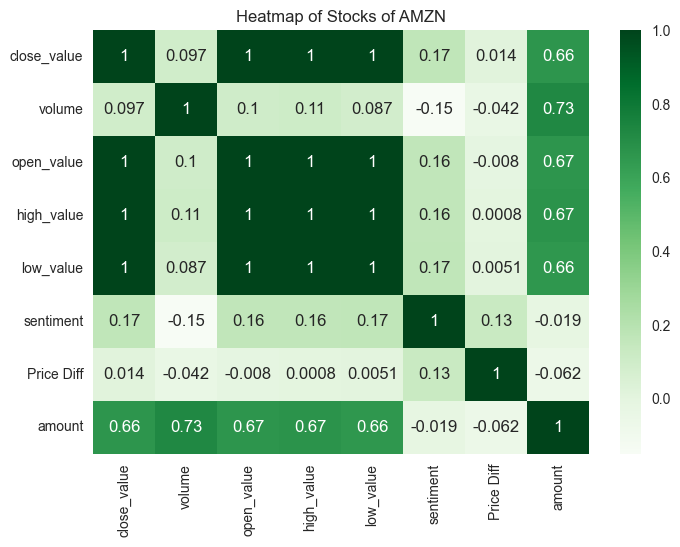

In [1159]:
correlations = stocks.corr()
# annot=True displays the correlation values
sns.heatmap(correlations, annot=True, cmap="Greens").set(title='Heatmap of Stocks of AMZN');

In [111]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import absolute
from numpy import sqrt
from numpy import std

In [114]:
print(stocks['open_value'])

0      1182.35
1      1172.00
2      1188.30
3      1205.00
4      1217.51
        ...   
361    1473.35
362    1473.35
363    1473.35
364    1510.80
365    1510.80
Name: open_value, Length: 366, dtype: float64


In [119]:
X = stocks[['open_value']]
Y = stocks['close_value']
cv = KFold(n_splits=10, random_state=1, shuffle=True)
models = LinearRegression()
scores = cross_val_score(models, X, Y, scoring='neg_mean_absolute_error',cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))


Accuracy: -22.601 (3.641)


In [1322]:
tsla_df = result

In [1323]:
tsla_df.head()

,tweet_id,body,comment_num,retweet_num,like_num,ticker_symbol,reaction,date
0,550441509175443456,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL,0,2015-01-01
1,550441672312512512,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL,-1,2015-01-01
2,550441732014223360,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,AMZN,-1,2015-01-01
3,550442977802207232,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,TSLA,0,2015-01-01
4,550443807834402816,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,0,2015-01-01


In [1331]:
tsla_df = tsla_df.loc[tsla_df['ticker_symbol'] == 'TSLA' ]
# tsla_df = tsla_df.reset_index(drop==True)

KeyError: 'ticker_symbol'

In [1325]:
tsla_df = tsla_df.reset_index(drop=True)

In [1332]:
tsla_df.tail()

,date,AAPL,AMZN,TSLA,MSFT,GOOG,GOOGL
57,"[datetime.date(2019, 3, 29)]",0.353191,0.360748,0.164767,0.394904,0.222222,0.272222
58,"[datetime.date(2019, 3, 30)]",0.421538,0.362832,0.031579,0.283019,0.120690,0.404255
59,"[datetime.date(2019, 3, 31)]",0.505495,0.534759,0.137371,0.349515,0.257143,0.428571
60,"[datetime.date(2019, 4, 1)]",0.300813,0.229794,0.147425,0.184783,0.021505,0.289017
61,"[datetime.date(2019, 4, 2)]",0.379397,0.260450,0.150778,0.317919,0.173228,0.316667


In [1282]:
reaction.loc[1553]
#1492


date     [datetime.date(2019, 4, 2)]
AAPL                        0.379397
AMZN                         0.26045
TSLA                        0.150778
MSFT                        0.317919
GOOG                        0.173228
GOOGL                       0.316667
Name: 1553, dtype: object

In [1333]:
tsla_df = reaction.loc[1492:1553]
# 1493
# 1551

In [1337]:
tsla_df.tail()

,date,AAPL,AMZN,TSLA,MSFT,GOOG,GOOGL
57,"[datetime.date(2019, 3, 29)]",0.353191,0.360748,0.164767,0.394904,0.222222,0.272222
58,"[datetime.date(2019, 3, 30)]",0.421538,0.362832,0.031579,0.283019,0.120690,0.404255
59,"[datetime.date(2019, 3, 31)]",0.505495,0.534759,0.137371,0.349515,0.257143,0.428571
60,"[datetime.date(2019, 4, 1)]",0.300813,0.229794,0.147425,0.184783,0.021505,0.289017
61,"[datetime.date(2019, 4, 2)]",0.379397,0.260450,0.150778,0.317919,0.173228,0.316667


In [1338]:
tsla_stocks.tail()
# tsla_df = tsla_df.drop('AMZN', index=1)

,close_value,volume,open_value,high_value,low_value,sentiment
57,279.86,5980355,278.70,280.16,274.500,NaN
58,279.86,5980355,278.70,280.16,274.500,NaN
59,279.86,5980355,278.70,280.16,274.500,NaN
60,289.18,8093134,282.62,289.20,281.281,NaN
61,285.88,5427184,288.30,289.44,283.880,NaN


In [1348]:
tsla_stocks['sentiment'] = tsla_df['TSLA']

In [1352]:
tsla_stocks.head()

,close_value,volume,open_value,high_value,low_value,sentiment
day_date,,,,,,
2019-01-31,307.02,12545190,301.00,311.5636,294.00,0.184713
2019-02-01,312.21,7263618,305.42,316.1000,303.50,0.153912
2019-02-02,312.21,7263618,305.42,316.1000,303.50,0.166415
2019-02-03,312.21,7263618,305.42,316.1000,303.50,0.193798
2019-02-04,312.89,7344076,312.98,315.3000,301.88,0.250213


In [1350]:

tsla_stocks = tsla_stocks.drop(['ticker_symbol'], axis=1)

In [1351]:
tsla_stocks.set_index('day_date', inplace=True)

In [1335]:
tsla_df = tsla_df.reset_index(drop=True)

In [1299]:
tsla_df.head()

,date,AAPL,AMZN,TSLA,MSFT,GOOG,GOOGL
0,"[datetime.date(2019, 1, 31)]",0.330049,0.162544,0.184713,0.316953,0.275168,0.316279
1,"[datetime.date(2019, 2, 1)]",0.364611,0.240582,0.153912,0.246445,0.256637,0.200000
2,"[datetime.date(2019, 2, 2)]",0.438961,0.406780,0.166415,0.362069,0.250000,0.351562
3,"[datetime.date(2019, 2, 3)]",0.559524,0.412088,0.193798,0.418605,0.145833,0.417266
4,"[datetime.date(2019, 2, 4)]",0.389677,0.307414,0.250213,0.386555,0.291304,0.239688


In [1353]:
from sklearn.preprocessing import MinMaxScaler
tsla_st_copy = tsla_stocks.copy()
 #We create a copy so we can still refer to the original dataframe later
scaler = MinMaxScaler()

tsla_st_columns = tsla_stocks.columns
tsla_st_scaled = pd.DataFrame(scaler.fit_transform(tsla_st_copy), columns=tsla_st_columns)
tsla_st_scaled.head()

,close_value,volume,open_value,high_value,low_value,sentiment
0,0.764812,0.456361,0.689546,0.792394,0.646459,0.790821
1,0.849992,0.177693,0.763360,0.866689,0.801779,0.692453
2,0.849992,0.177693,0.763360,0.866689,0.801779,0.732382
3,0.849992,0.177693,0.763360,0.866689,0.801779,0.819835
4,0.861152,0.181938,0.889613,0.853587,0.775293,1.000000


<Axes: >

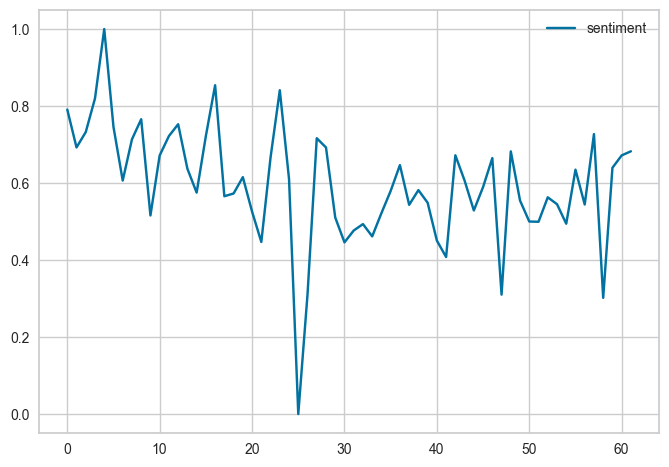

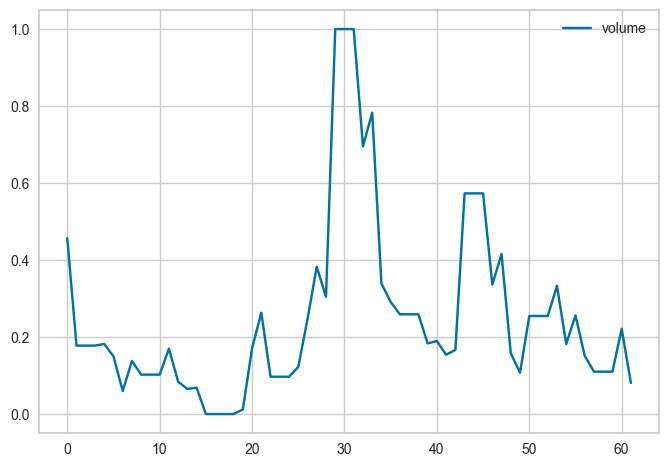

In [1362]:
tsla_st_scaled.plot(y='sentiment')
tsla_st_scaled.plot(y='volume')

In [1212]:
x = tsla_df['date']
y = tsla_df['TSLA']
df = px.data.gapminder().query("country=='Canada'")
fig = px.line(tsla_df, x="date", y="TSLA", title='Life expectancy in Canada')
fig.xla
fig.show()
